In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, statsmodels, (hdf5) h5netcdf

import numpy as np
import pandas as pd
import os, glob, re, sys
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline



In [2]:
from settings import *
from utils import * 
from functions import *


In [3]:
from dask.distributed import Client 
client = Client()
client

<Client: 'tcp://127.0.0.1:44225' processes=2 threads=2, memory=40.00 GiB>

# load data

In [4]:
df_cov = pd.read_csv(observed_warming_path_annual
                    ).rename(columns={'timebound_lower':'year'}
                    ).set_index('year')[['gmst']]
df_cov_smo = pd.DataFrame(apply_lowess(df_cov, df_cov.index, ntime=4))


<Axes: xlabel='year'>

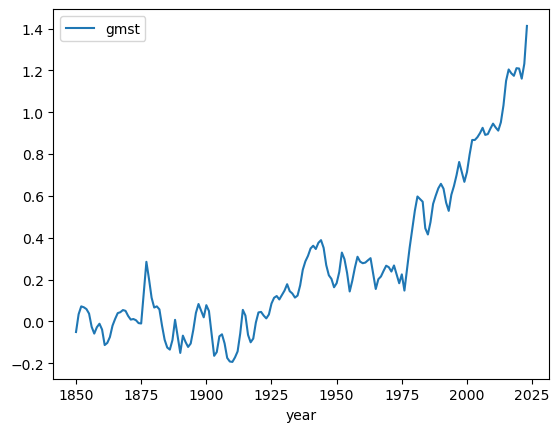

In [6]:
df_cov_smo.plot()

<Axes: xlabel='year'>

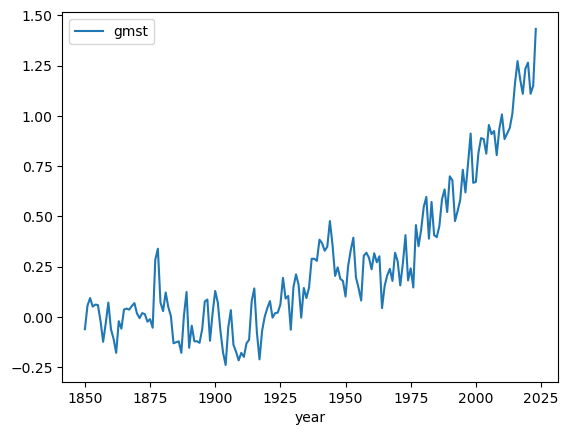

In [7]:
df_cov.plot()

In [10]:
df_cov

gmst
year          
1850 -0.060196
1851  0.057304
1852  0.094804
1853  0.052304
1854  0.062304
...        ...
2019  1.234804
2020  1.264804
2021  1.109804
2022  1.149804
2023  1.432304

[174 rows x 1 columns]

In [8]:
dataset = datasets[0]

da = open_model_data(model=dataset, 
                    period='start-end', 
                    scenario1='obsclim', 
                    scenario2=None, 
                    target_year=None, 
                    windowsize=None, 
                    chunk_version=1, #
                    variable='wbgt',
                    startyear=1950,
                    endyear=2000,  
                     engine='h5netcdf'
                   ).isel(lat=slice(150,152), lon=slice(350,352), time=slice(0,5000)).compute()

opening data for WBGT
chunking version 1
opening model data between 1950 and 2000


In [11]:
da

<xarray.DataArray 'WBGT' (time: 5000, lat: 2, lon: 2)>
array([[[19.75615706, 19.90258757],
        [19.87585909, 19.90593888]],

       [[20.05537979, 20.18502312],
        [19.9949488 , 19.77299228]],

       [[20.30053349, 20.32178192],
        [20.29915698, 20.19910947]],

       ...,

       [[26.46462852, 26.64859837],
        [26.76574452, 26.92892884]],

       [[26.60155391, 26.88724507],
        [26.73381408, 26.96972927]],

       [[25.40280723, 26.05232469],
        [25.56708188, 25.72415105]]])
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 1963-09-09
  * lat      (lat) float32 14.75 14.25
  * lon      (lon) float32 -4.75 -4.25
Attributes:
    units:    C

# Test run sf fxn here

loading data not really working 

In [12]:
norm_shift_fit(da, df_cov_smo, shift_sigma=False, by_month=True, round_decimals=4)

test: dask parallelized


<xarray.DataArray 'fit_params' (month: 12, lat: 2, lon: 2, params: 3)>
array([[[[ 1.91823163e+01,  2.13609737e+00,  1.68268107e+00],
         [ 1.98443089e+01,  2.50000000e-04,  1.66433644e+00]],

        [[ 1.98993397e+01,  2.50000000e-04,  1.66986072e+00],
         [ 1.92633014e+01,  2.63216638e+00,  1.68320878e+00]]],


       [[[ 2.12115917e+01,  2.50000000e-04,  1.82062614e+00],
         [ 2.13641415e+01,  2.50000000e-04,  1.83281040e+00]],

        [[ 2.13589077e+01,  2.50000000e-04,  1.82617784e+00],
         [ 2.13752689e+01,  2.50000000e-04,  1.83516943e+00]]],


       [[[ 2.27052269e+01,  0.00000000e+00,  1.76703322e+00],
         [ 2.28922806e+01,  0.00000000e+00,  1.72058225e+00]],

        [[ 2.29100704e+01,  0.00000000e+00,  1.78435278e+00],
         [ 2.29831810e+01,  0.00000000e+00,  1.80026293e+00]]],

...

       [[[ 2.66488353e+01, -5.01241646e+00,  1.72159440e+00],
         [ 2.55716724e+01,  0.00000000e+00,  1.64050186e+00]],

        [[ 2.65702113e+01, -4.62404686e+00,  1.69423600e+00],
         [ 2.56534729e+01,  0.00000000e+00,  1.71792448e+00]]],


       [[[ 2.25653496e+01,  2.50000000e-04,  1.64743721e+00],
         [ 2.30170479e+01,  2.50000000e-04,  1.67857015e+00]],

        [[ 2.22497270e+01,  2.18764345e+00,  1.65162156e+00],
         [ 2.30905495e+01,  2.50000000e-04,  1.62688720e+00]]],


       [[[ 2.09420263e+01, -3.48665534e+00,  2.14082015e+00],
         [ 2.11199764e+01, -3.30633867e+00,  2.11448501e+00]],

        [[ 2.03466415e+01,  0.00000000e+00,  2.09016609e+00],
         [ 2.12055125e+01, -3.33182419e+00,  2.11326967e+00]]]])
Coordinates:
  * lat      (lat) float32 14.75 14.25
  * lon      (lon) float32 -4.75 -4.25
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) <U5 'b0' 'b1' 'sigma'

# check params test data

In [15]:
indir = '/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_test/'
globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)


['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_test/test_shift-params10471507_0.nc', '/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_test/test_shift-params10471506_2.nc', '/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_test/test_shift-params10471508_1.nc']


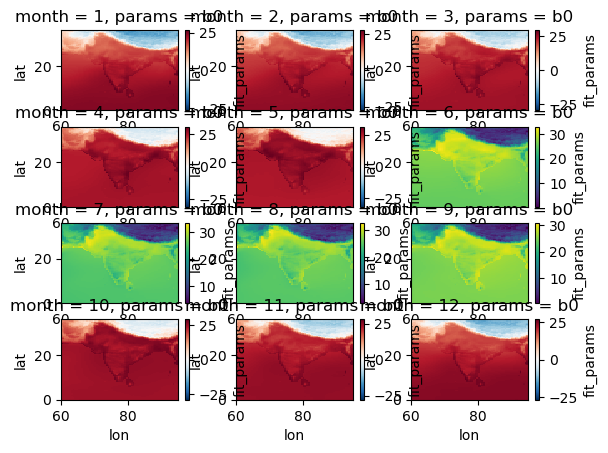

In [18]:
da_params = xr.open_dataarray(globbed[0])

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=0).plot(ax=ax) # ok

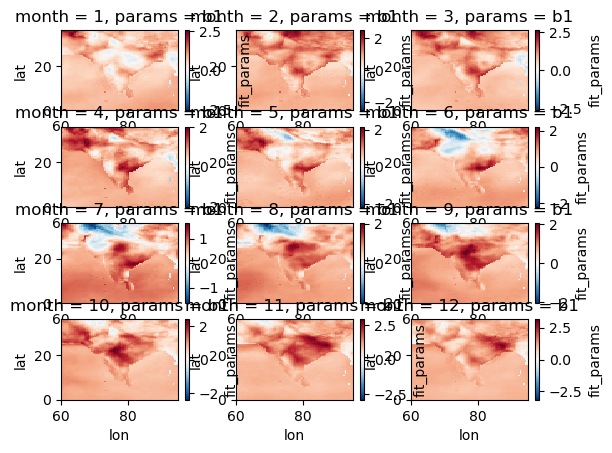

In [23]:
da_params = xr.open_dataarray(globbed[2])

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=1).plot(ax=ax) # ok

# Check again 

In [30]:
base_path = '/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/'
directories = sorted([
    d for d in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, d)) and d.startswith('output_feb25')
])
print(len(directories))
indir = directories[-4]

32


['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10471504/WBGT/ISIMIP3a/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc']


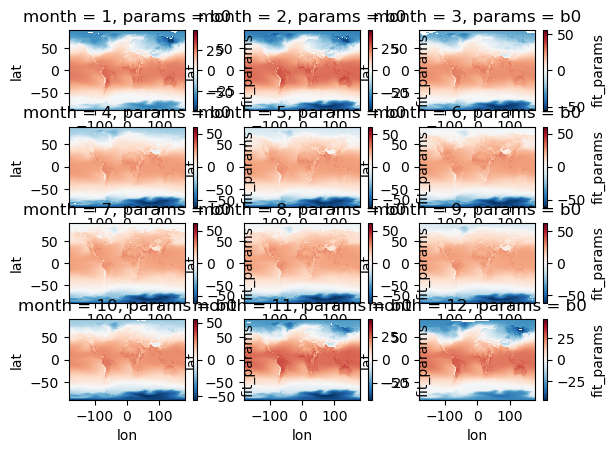

In [33]:
indir

globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=0).plot(ax=ax) # ok

# it worked !!! Just a little bit of nans, seem mostly to be at high latitudes, should not have a big impact... 

# Test running on models

In [4]:
da = open_model_data(model=GCMs[idx_models], 
                    period='start-end', 
                    scenario1=flags['experiment'], 
                    scenario2=None, 
                    target_year=None, 
                    windowsize=None, 
                    chunk_version=flags['chunk_version'], #
                    variable=var,
                    startyear=flags['shift_period'][0],
                    endyear=flags['shift_period'][1],  
                   ) 

/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_jan25/WBGT/ISIMIP3b/historical/CanESM5 /scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_jan25/WBGT/ISIMIP3b/ssp370/CanESM5
opening data for wbgt
chunking version 0
opening model data between 1901 and 2019


/apps/brussel/RL8/zen4/software/xarray/2023.9.0-gfbf-2023a/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [5]:
da

<xarray.DataArray 'wbgt' (time: 43464, lat: 360, lon: 720)>
dask.array<getitem, shape=(43464, 360, 720), dtype=float64, chunksize=(43464, 90, 120), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-01-02 ... 2019-12-31
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Attributes:
    units:    C

# Check all in folder

In [87]:
base_path = '/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/'
directories = sorted([
    d for d in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, d)) and d.startswith('output_feb25')
])
print(len(directories))
directories

6


['output_feb25-10469374',
 'output_feb25-10469375',
 'output_feb25-10471504',
 'output_feb25-10472060',
 'output_feb25-10472061',
 'output_feb25-10472062']

['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10469374/WBGT/ISIMIP3a/20CRv3-W5E5/20crv3-w5e5_obsclim_WBGT_params_shift_loc_mon_1950_2019.nc']


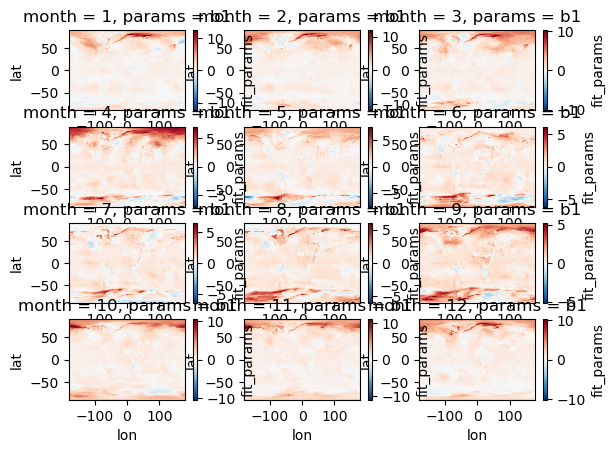

In [88]:

indir = directories[0]
globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=1).plot(ax=ax) # ok

In [89]:
nan_counts = da_params.isnull().sum(dim=["lat", "lon"])  # Adjust dims as needed
nan_counts

<xarray.DataArray 'fit_params' (month: 12, params: 3)>
array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'

['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10469375/WBGT/ISIMIP3a/20CRv3-ERA5/20crv3-era5_obsclim_WBGT_params_shift_loc_mon_1950_2019.nc']


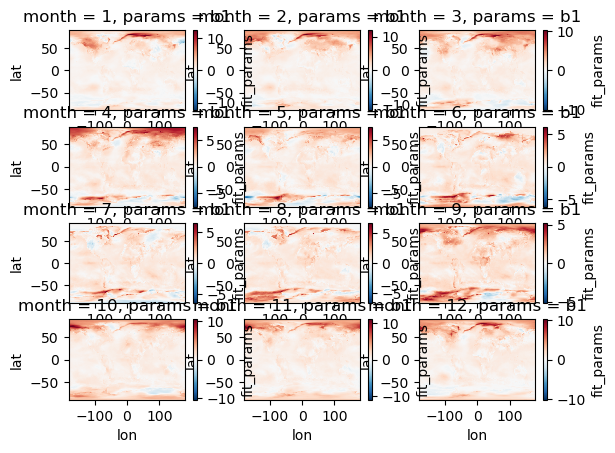

In [90]:
indir = directories[1]
globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=1).plot(ax=ax) # problem!

In [91]:
nan_counts = da_params.isnull().sum(dim=["lat", "lon"])  # Adjust dims as needed
nan_counts

<xarray.DataArray 'fit_params' (month: 12, params: 3)>
array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'

['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10471504/WBGT/ISIMIP3a/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc']


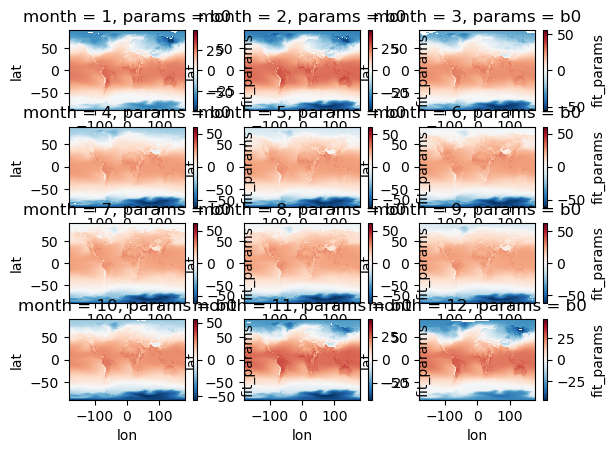

In [92]:
indir = directories[2]

globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=0).plot(ax=ax)

<xarray.DataArray 'fit_params' (month: 12, params: 3)>
array([[12, 12, 12],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [49, 49, 49],
       [ 5,  5,  5],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'

(array([ 173.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  110.,
         185., 4185.]),
 array([-82.75      , -74.15000153, -65.55000305, -56.95000076,
        -48.34999847, -39.75      , -31.14999962, -22.54999924,
        -13.94999981,  -5.3499999 ,   3.25      ,  11.85000038,
         20.45000076,  29.04999924,  37.65000153,  46.25      ,
         54.84999847,  63.45000076,  72.05000305,  80.65000153,
         89.25      ]),
 <BarContainer object of 20 artists>)

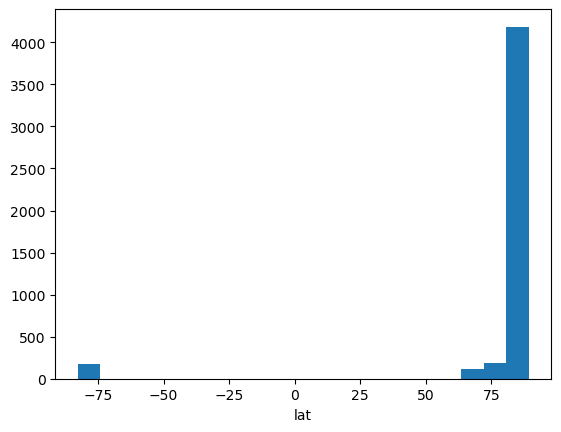

In [94]:
nan_indices = da_params.isnull().stack(z=("lat", "lon"))  # Stack lat/lon into a single dimension
nan_indices = nan_indices.where(nan_indices, drop=True)  # Keep only NaN values
lat_lon_indices = nan_indices.z  # Extract the combined indices
lat_lon_indices["lat"].plot.hist(bins=20)
# high latitudes... shouldn't have a big impact - but would be good to somehow fix it 

['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10472060/WBGT/ISIMIP3a/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_params_shift_loc_mon_1950_2019.nc']


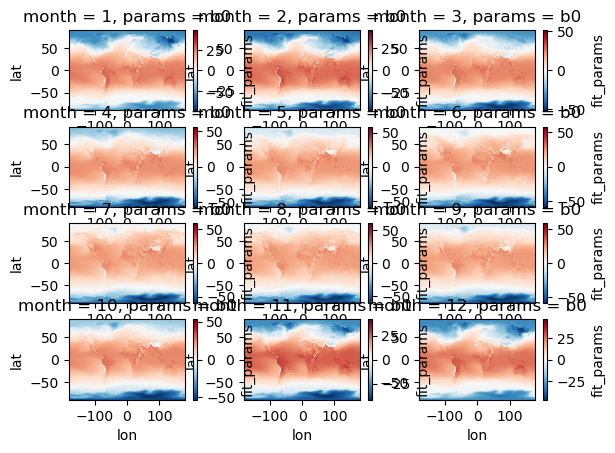

In [95]:
indir = directories[3]

globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=0).plot(ax=ax)

In [96]:
nan_counts = da_params.isnull().sum(dim=["lat", "lon"])  # Adjust dims as needed
nan_counts

<xarray.DataArray 'fit_params' (month: 12, params: 3)>
array([[16, 16, 16],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 3,  3,  3],
       [17, 17, 17],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'

(array([20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., 16.]),
 array([-82.25      , -74.47499847, -66.69999695, -58.92499924,
        -51.15000153, -43.375     , -35.59999847, -27.82500076,
        -20.04999924, -12.27499962,  -4.5       ,   3.2750001 ,
         11.05000019,  18.82500076,  26.60000038,  34.375     ,
         42.15000153,  49.92499924,  57.70000076,  65.47499847,
         73.25      ]),
 <BarContainer object of 20 artists>)

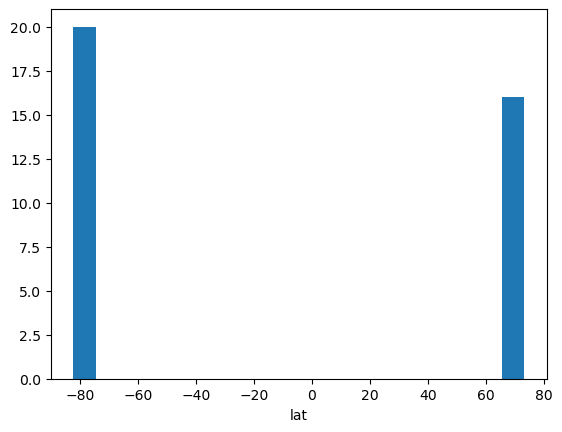

In [97]:
nan_indices = da_params.isnull().stack(z=("lat", "lon"))  # Stack lat/lon into a single dimension
nan_indices = nan_indices.where(nan_indices, drop=True)  # Keep only NaN values
lat_lon_indices = nan_indices.z  # Extract the combined indices
lat_lon_indices["lat"].plot.hist(bins=20)

# high latitudes... shouldn't have a big impact - but would be good to somehow fix it 

['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10472061/WBGT/ISIMIP3a/20CRv3-ERA5/20crv3-era5_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc']


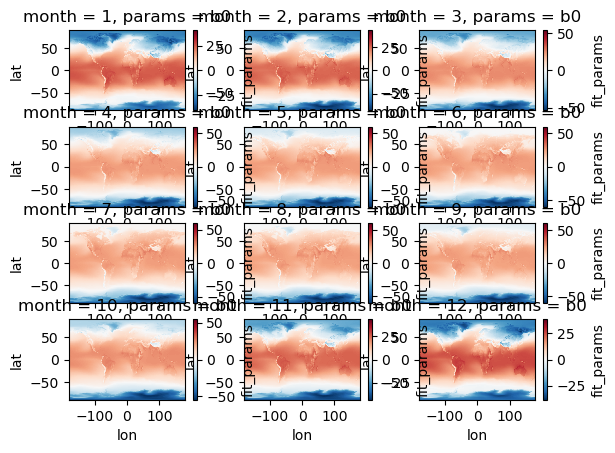

In [98]:
indir = directories[4]

globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=0).plot(ax=ax)

In [99]:
nan_counts = da_params.isnull().sum(dim=["lat", "lon"])  # Adjust dims as needed
nan_counts

<xarray.DataArray 'fit_params' (month: 12, params: 3)>
array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [42, 42, 42],
       [ 5,  5,  5],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'

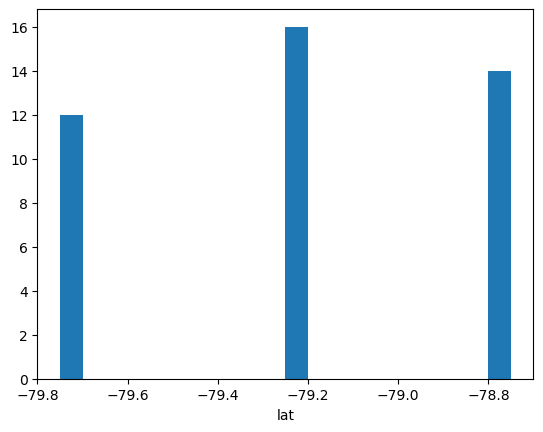

In [100]:
nan_indices = da_params.isnull().stack(z=("lat", "lon"))  # Stack lat/lon into a single dimension
nan_indices = nan_indices.where(nan_indices, drop=True)  # Keep only NaN values
lat_lon_indices = nan_indices.z  # Extract the combined indices
lat_lon_indices["lat"].plot.hist(bins=20);

['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10472062/WBGT/ISIMIP3a/20CRv3-W5E5/20crv3-w5e5_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc']


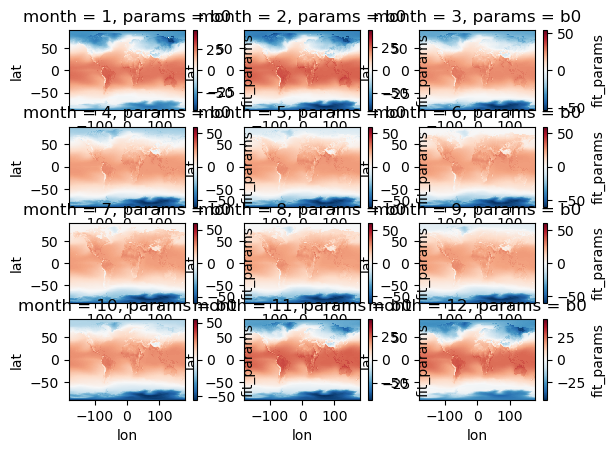

In [101]:
indir = directories[5]

globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=0).plot(ax=ax)

In [102]:
nan_counts = da_params.isnull().sum(dim=["lat", "lon"])  # Adjust dims as needed
nan_counts

<xarray.DataArray 'fit_params' (month: 12, params: 3)>
array([[12, 12, 12],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [49, 49, 49],
       [ 5,  5,  5],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'

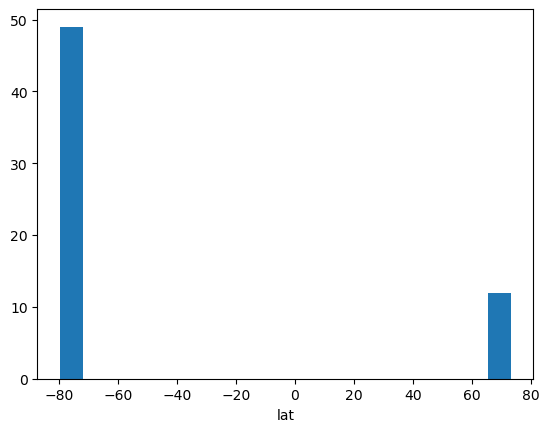

In [103]:
nan_indices = da_params.isnull().stack(z=("lat", "lon"))  # Stack lat/lon into a single dimension
nan_indices = nan_indices.where(nan_indices, drop=True)  # Keep only NaN values
lat_lon_indices = nan_indices.z  # Extract the combined indices
lat_lon_indices["lat"].plot.hist(bins=20);

# Full data 

20CRv3-ERA5
- 1901-2019 1e-3
- 1950-2019 OK - this is actually with high tol! (1e-5)

20CRv3-W5E5
- 1950-2019 OK- this is actually with high tol! (1e-5)
- 1901-2019 1e-3

GSWP3-W5E5
- 1e-3 both

## To do:
- make all with same tolerance level (try again 1e-5) with the nan option 
- try to fix nan pixels somehow, understand why (maybe WBGT values not properly computed?)

/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_shift-fit/forster2024-lowtol-nan/WBGT/ISIMIP3a/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc


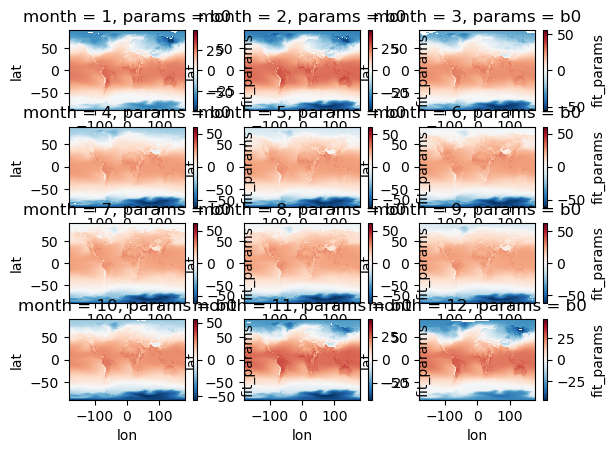

In [7]:
indir = f'/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_shift-fit/forster2024-lowtol-nan/WBGT/ISIMIP3a/{datasets[0]}'
filepath=glob.glob(os.path.join(indir, '*.nc'))[0]
print(filepath)
da_params = xr.open_dataarray(filepath)

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=0).plot(ax=ax)

In [8]:
nan_counts = da_params.isnull().sum(dim=["lat", "lon"])  # Adjust dims as needed
print(nan_counts.sum(dim='month'))
nan_counts

<xarray.DataArray 'fit_params' (params: 3)>
array([4838, 4838, 4838])
Coordinates:
  * params   (params) object 'b0' 'b1' 'sigma'


<xarray.DataArray 'fit_params' (month: 12, params: 3)>
array([[ 442,  442,  442],
       [ 170,  170,  170],
       [1979, 1979, 1979],
       [  22,   22,   22],
       [   0,    0,    0],
       [   0,    0,    0],
       [  94,   94,   94],
       [  35,   35,   35],
       [  74,   74,   74],
       [ 286,  286,  286],
       [ 100,  100,  100],
       [1636, 1636, 1636]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'

In [9]:
4838 / (da_params.shape[1] * da_params.shape[2]) # 1.8% of pixels missing 

0.018665123456790122

(array([ 173.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  110.,
         185., 4185.]),
 array([-82.75      , -74.15000153, -65.55000305, -56.95000076,
        -48.34999847, -39.75      , -31.14999962, -22.54999924,
        -13.94999981,  -5.3499999 ,   3.25      ,  11.85000038,
         20.45000076,  29.04999924,  37.65000153,  46.25      ,
         54.84999847,  63.45000076,  72.05000305,  80.65000153,
         89.25      ]),
 <BarContainer object of 20 artists>)

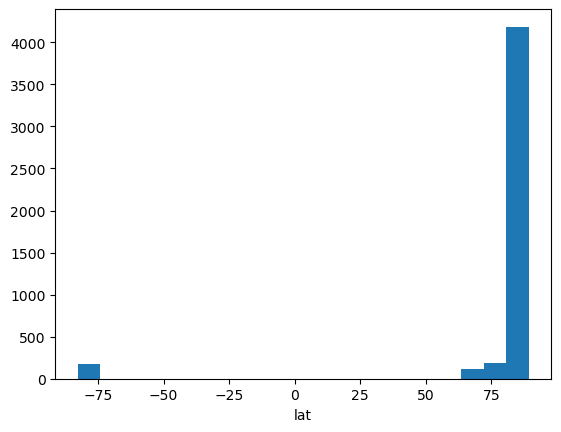

In [10]:
nan_indices = da_params.isnull().stack(z=("lat", "lon"))  # Stack lat/lon into a single dimension
nan_indices = nan_indices.where(nan_indices, drop=True)  # Keep only NaN values
lat_lon_indices = nan_indices.z  # Extract the combined indices
lat_lon_indices["lat"].plot.hist(bins=20)

## investigate what is happening in these pixels 

In [11]:
lat_lon_indices[0]

<xarray.DataArray 'z' ()>
array((89.25, -89.75), dtype=object)
Coordinates:
    z        object (89.25, -89.75)
    lat      float32 89.25
    lon      float32 -89.75

In [12]:
dataset = 'GSWP3-W5E5'
flags['models']='ISIMIP3a'
da = open_model_data(model=dataset, 
                    period='start-end', 
                    scenario1='obsclim', 
                    scenario2=None, 
                    target_year=None, 
                    windowsize=None, 
                    chunk_version=2, #
                    variable='wbgt',
                    startyear=1901,
                    endyear=2000,  
                     engine='h5netcdf'
                   ).sel(lat=lat_lon_indices[0].lat, lon=lat_lon_indices[0].lon)

opening data for WBGT
chunking version 2
opening model data between 1901 and 2000


In [13]:
dir1=os.path.join(scratchdirs, 'output_jan25', 'WBGT', flags['models'], 'obsclim', dataset ) # if you always change flags metric you can also replace with fxn 


In [15]:
variable='wbgt'
filepaths=get_filepaths(variable.upper(),dir1) # 'WBGT' not 'wbgt' in filename: possibly change for coherence
filepaths

['/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_jan25/WBGT/ISIMIP3a/obsclim/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_1901_1910.nc',
 '/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_jan25/WBGT/ISIMIP3a/obsclim/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_1911_1920.nc',
 '/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_jan25/WBGT/ISIMIP3a/obsclim/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_1921_1930.nc',
 '/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_jan25/WBGT/ISIMIP3a/obsclim/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_1931_1940.nc',
 '/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_jan25/WBGT/ISIMIP3a/obsclim/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_1941_1950.nc',
 '/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_jan25/WBGT/ISIMIP3a/obsclim/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_1951_1960.nc',
 '/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_jan25/WBGT/ISIMIP3a/obsclim/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_1961_19

In [17]:
# Define a preprocessing function to subset the data
def preprocess_select(ds, lat=lat_lon_indices[0].lat, lon=lat_lon_indices[0].lon):
    return ds.sel(lat=lat, lon=lon)

# Open the dataset with preprocessing
ds_subset = xr.open_mfdataset(
    filepaths,  # Path to your files
    preprocess=preprocess_select,  # Apply the subset during loading
    combine="by_coords",     # Adjust based on your file structure,
    engine='h5netcdf'
)

da = ds_subset['WBGT'].compute()

2025-02-06 14:53:39,786 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('getitem-open_dataset-WBGT-concatenate-eddcd559b83d59c0bf08d82e76e70ce7', 10))" coro=<Worker.execute() done, defined at /apps/brussel/RL8/zen4/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/distributed/worker_state_machine.py:3608>> ended with CancelledError
2025-02-06 14:53:39,786 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('getitem-open_dataset-WBGT-concatenate-eddcd559b83d59c0bf08d82e76e70ce7', 8))" coro=<Worker.execute() done, defined at /apps/brussel/RL8/zen4/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/distributed/worker_state_machine.py:3608>> ended with CancelledError


KeyboardInterrupt: 

## back to business

/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_shift-fit/forster2024-lowtol-nan/WBGT/ISIMIP3a/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_params_shift_loc_mon_1950_2019.nc


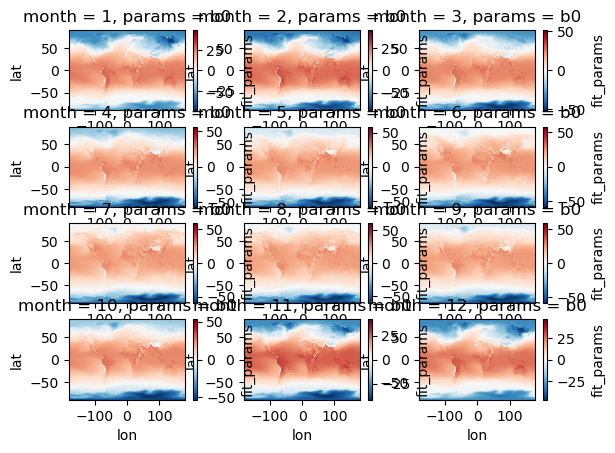

In [8]:
indir = f'/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_shift-fit/forster2024-lowtol-nan/WBGT/ISIMIP3a/{datasets[0]}'
filepath=glob.glob(os.path.join(indir, '*.nc'))[1]
print(filepath)
da_params = xr.open_dataarray(filepath)

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=0).plot(ax=ax)

/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_shift-fit/forster2024-lowtol-nan/WBGT/ISIMIP3a/20CRv3-ERA5/20crv3-era5_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc


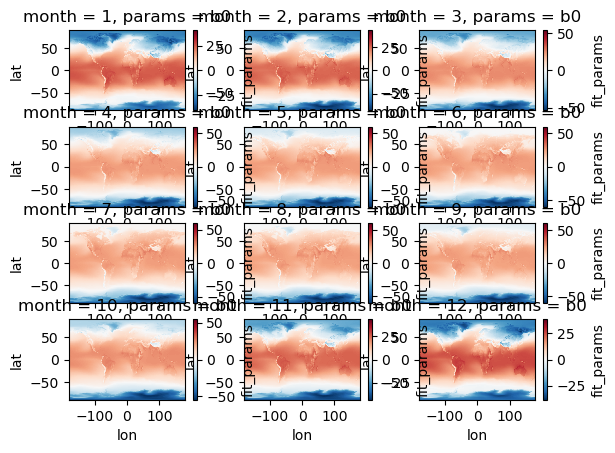

In [9]:
indir = f'/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_shift-fit/forster2024-lowtol-nan/WBGT/ISIMIP3a/{datasets[1]}'
filepath=glob.glob(os.path.join(indir, '*.nc'))[0]
print(filepath)
da_params = xr.open_dataarray(filepath)

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=0).plot(ax=ax)

/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_shift-fit/forster2024-lowtol-nan/WBGT/ISIMIP3a/20CRv3-ERA5/20crv3-era5_obsclim_WBGT_params_shift_loc_mon_1950_2019.nc


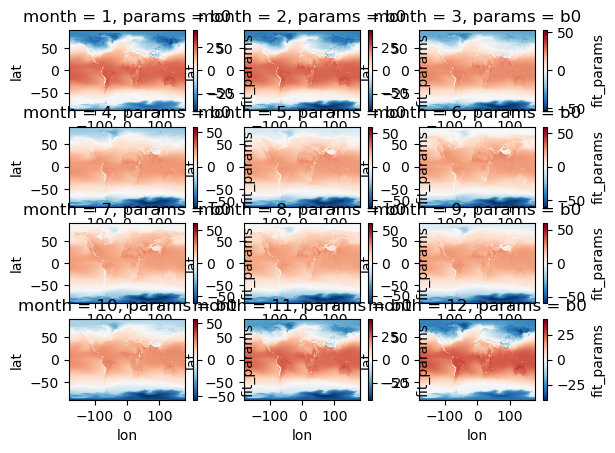

In [11]:
indir = f'/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_shift-fit/forster2024-lowtol-nan/WBGT/ISIMIP3a/{datasets[1]}'
filepath=glob.glob(os.path.join(indir, '*.nc'))[1]
print(filepath)
da_params = xr.open_dataarray(filepath)

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=0).plot(ax=ax)

/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_shift-fit/forster2024-lowtol-nan/WBGT/ISIMIP3a/20CRv3-W5E5/20crv3-w5e5_obsclim_WBGT_params_shift_loc_mon_1950_2019.nc


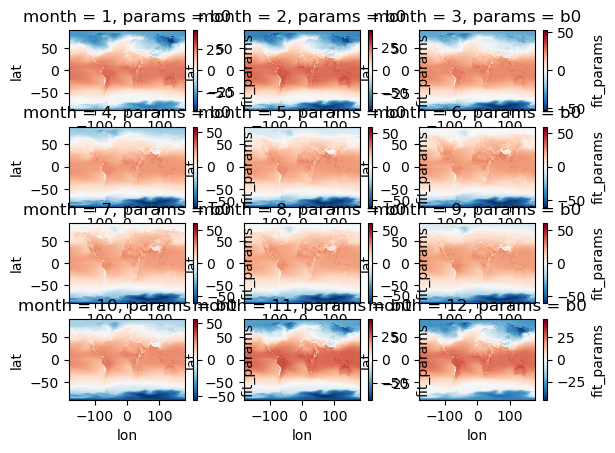

In [12]:
indir = f'/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_shift-fit/forster2024-lowtol-nan/WBGT/ISIMIP3a/{datasets[2]}'
filepath=glob.glob(os.path.join(indir, '*.nc'))[0]
print(filepath)
da_params = xr.open_dataarray(filepath)

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=0).plot(ax=ax)

/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_shift-fit/forster2024-lowtol-nan/WBGT/ISIMIP3a/20CRv3-W5E5/20crv3-w5e5_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc


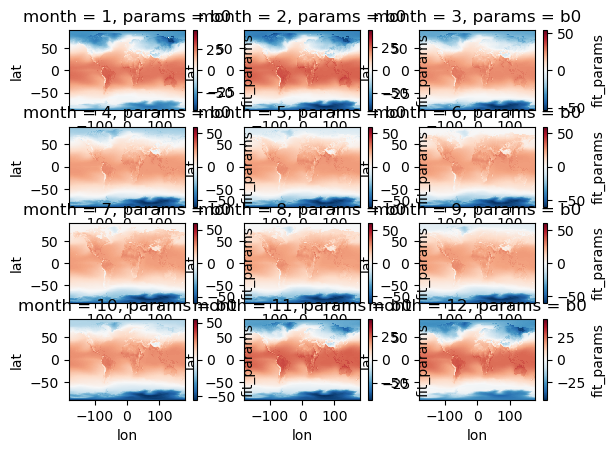

In [13]:
indir = f'/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_shift-fit/forster2024-lowtol-nan/WBGT/ISIMIP3a/{datasets[2]}'
filepath=glob.glob(os.path.join(indir, '*.nc'))[1]
print(filepath)
da_params = xr.open_dataarray(filepath)

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=0).plot(ax=ax)

# Visualize nan pixel data

# Visualize log-like fxn

In [22]:
import numpy as np
import matplotlib.pyplot as plt


In [23]:
da = open_model_data(model=datasets[0], 
                    period='start-end', 
                    scenario1='obsclim', 
                    scenario2=None, 
                    target_year=None, 
                    windowsize=None, 
                    chunk_version=1, #
                    variable='wbgt',
                    startyear=1950,
                    endyear=2000,  
                   ) 

opening data for WBGT
chunking version 1
opening model data between 1950 and 2000


In [ ]:
data = da.isel(lat=slice(150,152), lon=slice(350,352), time=slice(0,5000)).compute()
data


In [10]:
# open and smooth covariate (GMST)
df_cov = pd.read_csv(observed_warming_path_annual
                    ).rename(columns={'timebound_lower':'year'}
                    ).set_index('year')[['gmst']]
df_cov_smo = pd.DataFrame(apply_lowess(df_cov, df_cov.index, ntime=4))

In [11]:
da_params = norm_shift_fit(data,
                                                   df_cov_smo, 
                                                   shift_sigma=flags['shift_sigma'], 
                                                   by_month=True)

test: dask parallelized


In [73]:

# Define ranges for b0 and b1
b0_range = np.linspace(-50, 50, 100)  # Adjust range based on your data
b1_range = np.linspace(-10, 10, 100)
b0, b1 = np.meshgrid(b0_range, b1_range)

# Define a fixed value for sigma
sigma = np.std(data)  # Use the initial guess or a realistic value

# Evaluate the log-likelihood
loglike_values = np.zeros_like(b0)

for i in range(b0.shape[0]):
    for j in range(b0.shape[1]):
        params = [b0[i, j], b1[i, j], sigma]
        loc, scale = norm_cov.get_params(norm_cov, params, cov)
        loglike_values[i, j] = np.sum(sp.stats.norm.logpdf(data, loc=loc, scale=scale))

# Plot the contour
plt.figure(figsize=(8, 6))
contour = plt.contourf(b0, b1, loglike_values, levels=50, cmap="viridis")
plt.colorbar(contour, label="Log-Likelihood")
plt.xlabel("b0 (Intercept)")
plt.ylabel("b1 (Slope)")
plt.title("Log-Likelihood Contour for b0 and b1")
plt.show()


NameError: name 'norm_cov' is not defined

# Check all in folder again

In [5]:
base_path = '/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/'
directories = sorted([
    d for d in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, d)) and d.startswith('output_feb25')
])
print(len(directories))
directories

10


['output_feb25-10472783',
 'output_feb25-10472784',
 'output_feb25-10472785',
 'output_feb25-10472813',
 'output_feb25-10472932',
 'output_feb25-10473305',
 'output_feb25-10473307',
 'output_feb25-10473308',
 'output_feb25-10473309',
 'output_feb25-10473310']

In [6]:
indir = directories[0]
globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])
da_params


['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10472783/WBGT/ISIMIP3a/20CRv3-W5E5/20crv3-w5e5_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc']


<xarray.DataArray 'fit_params' (month: 12, lat: 360, lon: 720, params: 4)>
[12441600 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma_b0' 'sigma_b1'

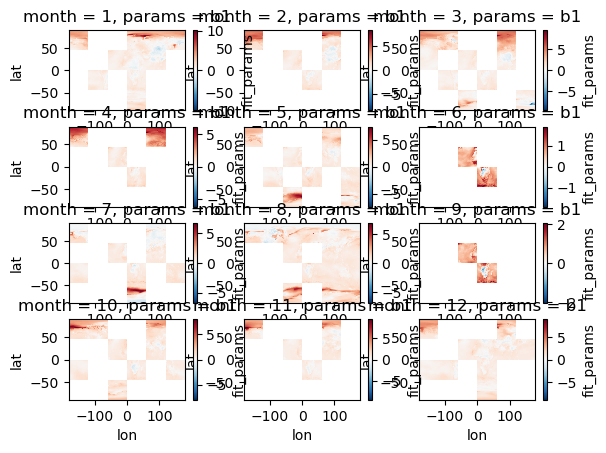

In [7]:
fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=1).plot(ax=ax) #NO

In [10]:
indir = directories[1]
globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])
da_params


['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10472784/WBGT/ISIMIP3a/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc']


<xarray.DataArray 'fit_params' (month: 12, lat: 360, lon: 720, params: 4)>
[12441600 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma_b0' 'sigma_b1'

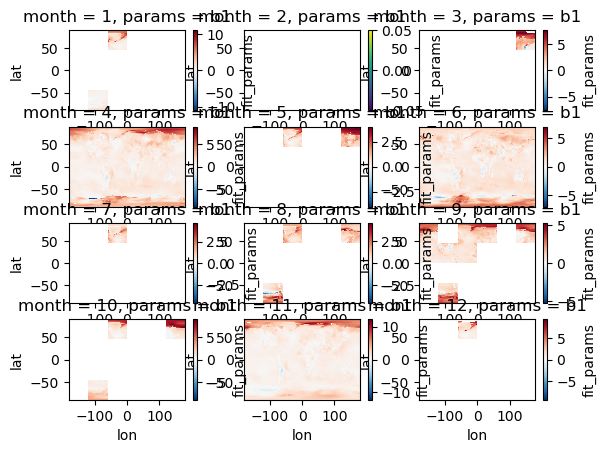

In [11]:
fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=1).plot(ax=ax) # NO

In [12]:
indir = directories[2]
globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])
da_params

['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10472785/WBGT/ISIMIP3a/20CRv3-ERA5/20crv3-era5_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc']


<xarray.DataArray 'fit_params' (month: 12, lat: 360, lon: 720, params: 4)>
[12441600 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma_b0' 'sigma_b1'

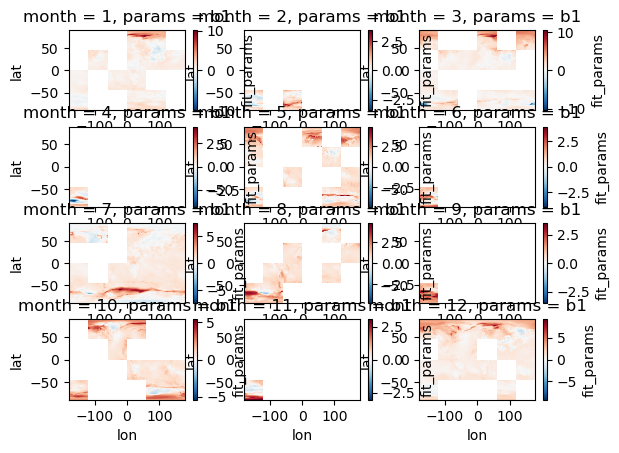

In [13]:

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=1).plot(ax=ax) # ok

In [15]:
indir = directories[3]
globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])
da_params


['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10472813/WBGT/ISIMIP3b/CanESM5/canesm5_r1i1p1f1_w5e5_historical_WBGT_params_shift_loc_mon_1901_2019.nc']


<xarray.DataArray 'fit_params' (month: 12, lat: 360, lon: 720, params: 3)>
[9331200 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'

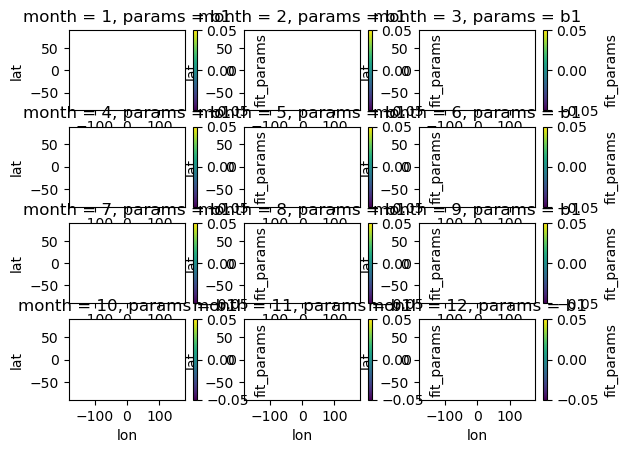

In [16]:
fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=1).plot(ax=ax) # ok

['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10472932/WBGT/ISIMIP3b/CanESM5/canesm5_r1i1p1f1_w5e5_historical_WBGT_params_shift_loc_mon_1901_2019.nc']


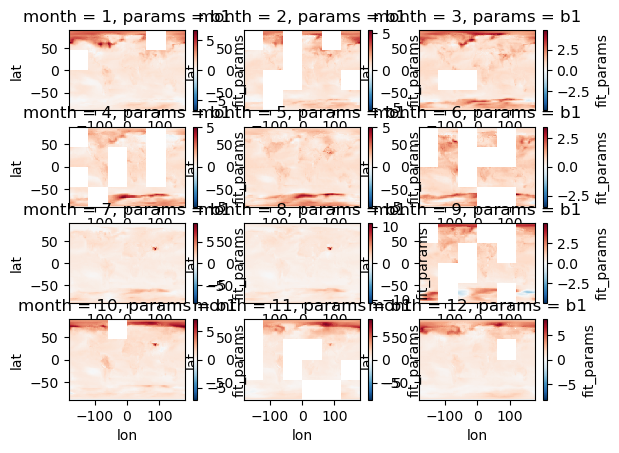

In [17]:
indir = directories[4]
globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=1).plot(ax=ax) # ok

In [18]:
da_params

<xarray.DataArray 'fit_params' (month: 12, lat: 360, lon: 720, params: 3)>
[9331200 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'

['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10473305/WBGT/ISIMIP3b/CanESM5/canesm5_r1i1p1f1_w5e5_historical_WBGT_params_shift_loc_mon_1901_2019.nc']


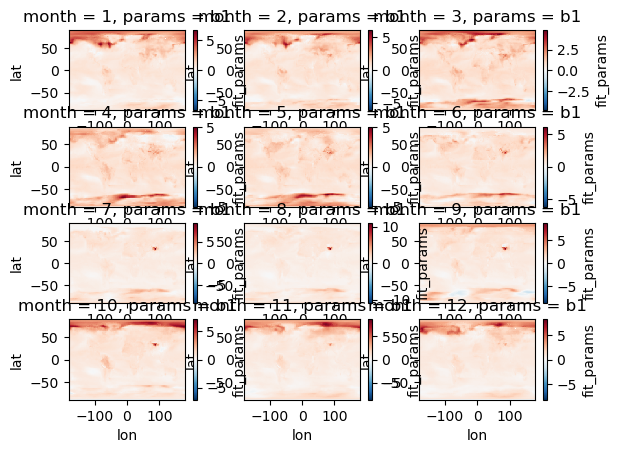

In [19]:
indir = directories[5]
globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=1).plot(ax=ax) # ok

In [20]:
da_params

<xarray.DataArray 'fit_params' (month: 12, lat: 360, lon: 720, params: 3)>
[9331200 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'

['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10473307/WBGT/ISIMIP3a/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_params_shift_loc_mon_1950_2019.nc']


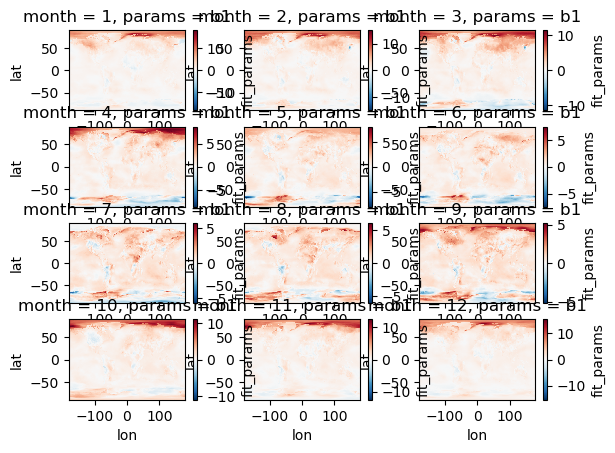

In [21]:
indir = directories[6]
globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=1).plot(ax=ax) # ok

In [22]:
da_params

<xarray.DataArray 'fit_params' (month: 12, lat: 360, lon: 720, params: 3)>
[9331200 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'

['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10473308/WBGT/ISIMIP3a/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc']


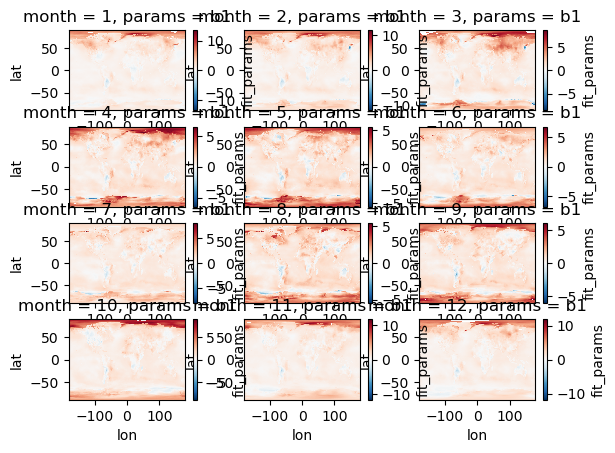

In [23]:
indir = directories[7]
globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=1).plot(ax=ax) # ok

In [24]:
da_params

<xarray.DataArray 'fit_params' (month: 12, lat: 360, lon: 720, params: 3)>
[9331200 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'

['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10473309/WBGT/ISIMIP3a/20CRv3-ERA5/20crv3-era5_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc']


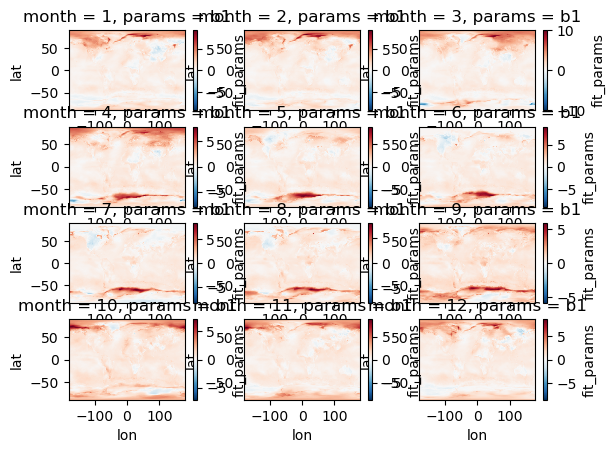

In [25]:
indir = directories[8]
globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=1).plot(ax=ax) # ok

In [26]:
da_params

<xarray.DataArray 'fit_params' (month: 12, lat: 360, lon: 720, params: 3)>
[9331200 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'

['/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_feb25-10473310/WBGT/ISIMIP3a/20CRv3-W5E5/20crv3-w5e5_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc']


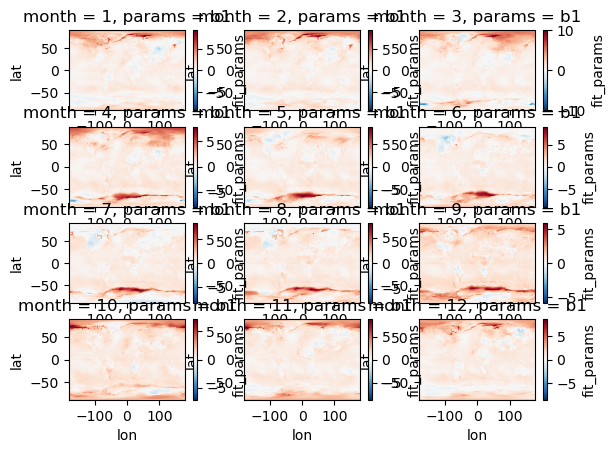

In [27]:
indir = directories[9]
globbed=glob.glob(os.path.join(base_path,indir,'**', '*.nc'), recursive=True)
print(globbed)
da_params = xr.open_dataarray(globbed[0])

fig, axes = plt.subplots(4,3)
for i in range(0,12):
    ax=axes.flatten()[i]
    da_params.isel(month=i, params=1).plot(ax=ax) # ok

In [28]:
da_params

<xarray.DataArray 'fit_params' (month: 12, lat: 360, lon: 720, params: 3)>
[9331200 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'